<a href="https://colab.research.google.com/github/cgyireh1/Chatbot_project/blob/main/notebook/chatbot_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Medical Chatbot
This project involves developing a **Medical Chatbot** using **MedQuad dataset (Medical Question-Answer)** from [kaggle](https://www.kaggle.com/datasets/thedevastator/comprehensive-medical-q-a-dataset/datahttps://www.kaggle.com/datasets/thedevastator/comprehensive-medical-q-a-dataset/data). The dataset includes questions about treatments, chronic diseases, medical protocols, and answers from healthcare professionals such as doctors, nurses, and pharmacists.

The aims of the project is to assist patients by providing reliable medical information and supporting healthcare professionals by automating responses to common medical inquiries.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importing Libraries

In [ ]:
import re
import nltk
import json
import torch
import random
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import LabelBinarizer
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import Sequential, load_model
from sklearn.metrics import classification_report, accuracy_score, f1_score

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

## Data Inspection

* Load data
* Print columns
* Print dataset shape (Data size)
* Check for missing data
* Display first few rows



In [ ]:
# Load your dataset
file_path = '/content/drive/MyDrive/Medical_Q&A_Dataset.csv'
df = pd.read_csv(file_path)

print("Columns in the dataset:", df.columns, '\n' )

print("shape of the dataset:", df.shape, '\n')

print("Basic Info:")
print(df.info(), '\n')

# Check for missing data
print("\nMissing data:", df.isnull().sum())

Columns in the dataset: Index(['qtype', 'Question', 'Answer'], dtype='object') 

shape of the dataset: (16407, 3) 

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16407 entries, 0 to 16406
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   qtype     16407 non-null  object
 1   Question  16407 non-null  object
 2   Answer    16407 non-null  object
dtypes: object(3)
memory usage: 384.7+ KB
None 


Missing data: qtype       0
Question    0
Answer      0
dtype: int64


In [ ]:
print("\nFirst 5 rows of the dataset:")
df.head()


First 5 rows of the dataset:


,qtype,Question,Answer
0,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,LCMV infections can occur after exposure to fr...
1,symptoms,What are the symptoms of Lymphocytic Choriomen...,LCMV is most commonly recognized as causing ne...
2,susceptibility,Who is at risk for Lymphocytic Choriomeningiti...,Individuals of all ages who come into contact ...
3,exams and tests,How to diagnose Lymphocytic Choriomeningitis (...,"During the first phase of the disease, the mos..."
4,treatment,What are the treatments for Lymphocytic Chorio...,"Aseptic meningitis, encephalitis, or meningoen..."


## Data Preprocessing

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    return text


df['Question'] = df['Question'].apply(preprocess)
df['Answer'] = df['Answer'].apply(preprocess)
df.head()

,qtype,Question,Answer
0,susceptibility,who is at risk for lymphocytic choriomeningiti...,lcmv infections can occur after exposure to fr...
1,symptoms,what are the symptoms of lymphocytic choriomen...,lcmv is most commonly recognized as causing ne...
2,susceptibility,who is at risk for lymphocytic choriomeningiti...,individuals of all ages who come into contact ...
3,exams and tests,how to diagnose lymphocytic choriomeningitis lcm,during the first phase of the disease the most...
4,treatment,what are the treatments for lymphocytic chorio...,aseptic meningitis encephalitis or meningoence...


In [ ]:
# Loading the BERT tokenizer & model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

intents = []
# Store question embeddings for similarity search
question_embeddings = []

for ind in df.index:
    question = df['Question'][ind].lower().strip()
    answer = df['Answer'][ind]
    qtype = df['qtype'][ind]
    intents.append({'qtype': qtype, 'question': question, 'answer': answer})

# Saving the intents
with open("med_quad.json", "w") as f:
    json.dump({'intents': intents}, f)

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Prepare the training data
words = []
classes = []
documents = []
lemmatizer = WordNetLemmatizer()
ignore_letters = ['?', '!', '.', ',']

for intent in intents:
    pattern = intent['question']
    words.extend(tokenizer.tokenize(pattern))
    documents.append((pattern, intent['qtype']))
    if intent['qtype'] not in classes:
        classes.append(intent['qtype'])
    question_embeddings.append(get_bert_embedding(pattern))

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('words.pkl', 'wb'))
pickle.dump(classes, open('classes.pkl', 'wb'))

In [ ]:
# data training
question_embeddings = np.array(question_embeddings)

training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    embedding = get_bert_embedding(document[0])
    output_row = label_binarizer.transform([document[1]])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

### Model Definition, Training, and Saving

In [ ]:
import tensorflow as tf
# Define model
model = Sequential()
model.add(Dense(128, input_shape=(train_x.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(train_y.shape[1], activation='softmax'))

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.9
)
# Compile & train
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
model.summary()

plot_model(model, to_file='model.png', show_shapes=True)

hist = model.fit(train_x, train_y, epochs=50, batch_size=64, verbose=1)
model.save('med-botmodel.keras')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │          98,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,296 (426.94 KB)

 Trainable params: 109,296 (426.94 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3324 - loss: 2.3062
Epoch 2/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6373 - loss: 1.1892
Epoch 3/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8340 - loss: 0.6697
Epoch 4/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9168 - loss: 0.3819
Epoch 5/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9515 - loss: 0.2485
Epoch 6/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9634 - loss: 0.1831
Epoch 7/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9726 - loss: 0.1416
Epoch 8/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9742 - loss: 0.1210
Epoch 9/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9810 - loss: 0.1010
Epoch 10/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9834 - loss: 0.0827
Epoch 11/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9856 - loss: 0.0730
Epoch 12/50
257/257 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

## Plotting Training Metrics

A visualization of the training performance of the model using the  **accuracy** and **loss** over epochs.

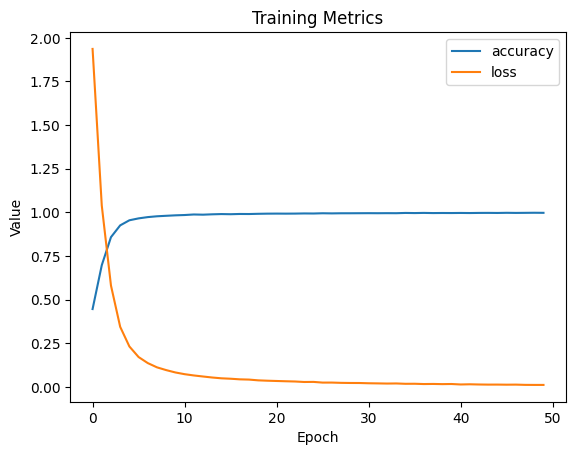

In [ ]:
import matplotlib.pyplot as plt

# Plot the training metrics
plt.plot(hist.history['accuracy'], label='accuracy')
plt.plot(hist.history['loss'], label='loss')
plt.title('Training Metrics')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# Evaluate model
y_pred = np.argmax(model.predict(train_x), axis=1)
y_true = np.argmax(train_y, axis=1)
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")
print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=1))


513/513 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Accuracy: 0.9993
F1 Score: 0.9992
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       727
           1       1.00      0.96      0.98        46
           2       1.00      1.00      1.00       235
           3       1.00      1.00      1.00       653
           4       1.00      1.00      1.00      1120
           5       1.00      1.00      1.00      1087
           6       1.00      1.00      1.00      4535
           7       1.00      1.00      1.00      1446
           8       1.00      1.00      1.00       361
           9       0.99      0.99      0.99       210
          10       1.00      1.00      1.00       395
          11       1.00      1.00      1.00        77
          12       1.00      0.00      0.00         1
          13       0.99      1.00      1.00       324
          14       1.00      1.00      1.00      2748
          15       1.00      1.00   

### Response Prediction

In [ ]:
# Response prediction and intent prediction
def prediction_class(sentence):
    embedding = get_bert_embedding(sentence)
    embedding = np.reshape(embedding, (1, -1))  # Reshaping to match the model input shape
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list


# get response function
def get_response(intents_list):
    if not intents_list:
        return "Sorry, I don't understand."
    tag = intents_list[0]['intent']
    print(f"Intent detected: {tag}")
    for intent in intents:
        if intent['qtype'] == tag:
            print(f"Response: {intent['answer']}")
            return intent['answer']
    return "Sorry, this is out of my knowledge base."


In [ ]:

# Response prediction and intent prediction
def prediction_class(sentence):
    """
    Predicts the intent of a sentence using BERT embeddings and the trained model.
    """
    embedding = get_bert_embedding(sentence)
    embedding = np.reshape(embedding, (1, -1))  # Reshaping to match the model input shape
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list


# Get response based on predicted intent
def get_response(intents_list):
    """
    Returns a response based on the predicted intent list.
    If no intent is found, returns a default response.
    """
    # If no intents are detected, return the default message
    if not intents_list:
        return "Sorry, I don't understand."

    # Extract the tag of the first predicted intent
    tag = intents_list[0]['intent']
    print(f"Intent detected: {tag}")

    # Find the corresponding response from the intents data
    for intent in intents:
        if intent['qtype'] == tag:
            print(f"Response: {intent['answer']}")
            return intent['answer']

    # If no matching intent found in the intents list, return the default response
    return "Sorry, this is out of my knowledge base."


# Load your model
model = load_model('med-botmodel.keras')

# Initialize the chat log list
chat_log = []

# Greeting responses
greeting_responses = ["hi", "hello", "hey"]

print("Hi! I'm your medical chatbot. What medical question can I help with?")

while True:
    # Get the user's message
    message = input("You: ")

    # Check if the message is a greeting and provide a default greeting response
    if any(greeting in message.lower() for greeting in greeting_responses):
        print("Bot: Hi! I'm your medical chatbot. What medical question can I help with?")
        continue  # Skip the rest of the loop and wait for the next message

    # Exit condition
    if message.lower() in ['quit', 'exit']:
        print("Was nice interacting with you 🫶")

        # Save the chat log as json file after interaction
        with open("chat_log.json", "w") as f:
            for entry in chat_log:
                f.write(f"You: {entry[0]}\nBot: {entry[1]}\n\n")
        break

    # Get the predicted intent and response from the model
    ints = prediction_class(message)
    response = get_response(ints)

    # Store the conversation in the chat_log
    chat_log.append((message, response))

    # Print the bot's response
    print(f"Bot: {response}")


Hi! I'm your medical chatbot. What medical question can I help with?
You: hello
Bot: Hi! I'm your medical chatbot. What medical question can I help with?
You: What are the symptoms of Lymphocytic Choriomeningitis (LCM) ?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
Intent detected: symptoms
Response: lcmv is most commonly recognized as causing neurological disease as its name implies though infection without symptoms or mild febrile illnesses are more common clinical manifestations                 for infected persons who do become ill onset of symptoms usually occurs 813 days after exposure to the virus as part of a biphasic febrile illness this initial phase which may last as long as a week typically begins with any or all of the following symptoms fever malaise lack of appetite muscle aches headache nausea and vomiting other symptoms appearing less frequently include sore throat cough joint pain chest pain testicular pain and parotid salivary gland pain                 following a few day

In [ ]:
!pip install gradio transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 95.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import numpy as np
import json
import pickle
import torch
import gradio as gr
from transformers import BertTokenizer, BertModel
from tensorflow.keras.models import load_model
from nltk.stem import WordNetLemmatizer

# Load necessary files
MODEL_PATH = "/content/med-botmodel.keras"
WORDS_PATH = "/content/words.pkl"
CLASSES_PATH = "/content/classes.pkl"
INTENTS_PATH = "/content/med_quad.json"

# Load model and necessary data
model = load_model(MODEL_PATH)
words = pickle.load(open(WORDS_PATH, "rb"))
classes = pickle.load(open(CLASSES_PATH, "rb"))

# Load intents JSON file
with open(INTENTS_PATH, "r") as json_file:
    intents_data = json.load(json_file)

# Load BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

lemmatizer = WordNetLemmatizer()

# Predefined responses for greetings and unknown queries
greeting_responses = [
    "Hello! How can I assist you today?",
    "Hi there! What medical question do you have?",
    "Hey! Feel free to ask any health-related questions."
]

unknown_responses = [
    "I'm sorry, I don't have enough information on that. Could you rephrase?",
    "That's beyond my knowledge base. Maybe a healthcare professional can help."
]

# Function to generate BERT embeddings
def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

# Predict intent function
def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    predictions = model.predict(embedding)[0]

    ERROR_THRESHOLD = 0.25
    intent_results = [[i, p] for i, p in enumerate(predictions) if p > ERROR_THRESHOLD]
    intent_results.sort(key=lambda x: x[1], reverse=True)

    return [{'intent': classes[i], 'probability': str(p)} for i, p in intent_results]

# Get response function with improved fallback handling
def get_response(predicted_intents, message):
    """
    Returns an appropriate response based on the predicted intent.
    """
    # Check if the message is a greeting
    if message.lower() in ["hi", "hello", "hey", "good morning", "good evening"]:
        return random.choice(greeting_responses)

    # If no intent is confidently detected, return a fallback response
    if not predicted_intents:
        return random.choice(unknown_responses)

    # Extract intent tag
    intent_tag = predicted_intents[0]['intent']

    # Search for matching intent in dataset
    for intent in intents_data["intents"]:
        if intent["qtype"] == intent_tag:
            return intent["answer"]

    return random.choice(unknown_responses)

# Gradio chatbot function with conversation history
def chatbot_response(message, chat_history=[]):
    predicted_intents = predict_class(message)
    response = get_response(predicted_intents, message)
    chat_history.append(("You: " + message, "Bot: " + response))

    return chat_history, chat_history

# Gradio UI
with gr.Blocks(theme="huggingface") as interface:
    gr.Markdown("## Your Healthcare Buddy 🤖 ")
    gr.Markdown("_Hi! I'm your medical chatbot. What medical question can I help with today?_")

    chat_history = gr.State([])  # Stores conversation history

    with gr.Row():
        chatbot_display = gr.Chatbot()  # Chatbot UI
        reset_button = gr.Button("Reset Chat")

    user_input = gr.Textbox(label="Your Message", placeholder="Type your question here...")

    # update chat history when user sends a message
    user_input.submit(chatbot_response, inputs=[user_input, chat_history], outputs=[chatbot_display, chat_history])

    # Reset button to chat history
    reset_button.click(lambda: ([], []), inputs=[], outputs=[chatbot_display, chat_history])

# Launch the Gradio interface
interface.launch()


/usr/local/lib/python3.11/dist-packages/gradio/blocks.py:1096: UserWarning: Cannot load huggingface. Caught Exception: 404 Client Error: Not Found for url: https://huggingface.co/api/spaces/huggingface (Request ID: Root=1-67c07386-646a40035e244f982aaa4c2d;d132752b-3c4d-4e19-b044-ae5a0339c10c)

Sorry, we can't find the page you are looking for.
  warnings.warn(f"Cannot load {theme}. Caught Exception: {str(e)}")
/usr/local/lib/python3.11/dist-packages/gradio/components/chatbot.py:285: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  warnings.warn(


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://52ad4f73d5710e2757.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
